In [1]:
from reservoir_rls import *
from lorenz63 import *
from sklearn import preprocessing
from scipy.stats import sem
import cma
from scipy.stats import kstest, norm, shapiro
from multiprocessing import Pool
from min_func import *
from tqdm import tqdm
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import pandas as pd



from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
data_length = 200000
step = 0.05
r_t = lambda x: r_t_const(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)
data = getLorenzData(data_length, r_t, dxdt, sample_tau = step)

sync_length = 200
train_length = 800
pred_length = 500

# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
scaled_data = np.copy(data)
scaled_data = np.ascontiguousarray(scaled_data)

-0.05210027118992914
18.92542301780254
-19.022413088306337


In [3]:
num_nodes = 210
num_tests = 100
res_seed = 1
base_res = reservoir(3,num_nodes,input_weight = 1, spectral_radius = 1, seed = res_seed)
mask = ['input_weight', 'regularization']
x0 = np.array([5, 5])
min_func = lambda x: vt_min_function_norm(scaled_data, x, mask, base_res.Win, base_res.A, \
     num_tests = num_tests,  num_nodes = num_nodes, pred_length = pred_length, train_length = train_length)
sigma = 2

In [ ]:
opts = cma.CMAOptions()
opts.set('popsize',6*x0.size)
opts.set('bounds', [0,10])
opts.set('seed', 5)
opts.set('verb_filenameprefix','cmaes_norm_res%d_redo\\' % res_seed)
results = cma.fmin(min_func, x0, sigma, options = opts)

In [ ]:
weights = np.linspace(4.5,5.5,50)
forgets = np.linspace(0,10,50)
func_vals = np.zeros((weights.size, forgets.size))

with tqdm(total = weights.size * forgets.size) as pbar:
    for i in range(weights.size):
        for j in range(forgets.size):
            func_vals[i,j] = min_func(np.array([weights[i], forgets[j]]))
            # print('Weight: %f, Log Reg: %f, Fval: %f'%(0.25*weights[i],-forgets[j]-2.0,func_vals[i,j]))
            np.savetxt('norm_func_vals_01.csv', func_vals, delimiter = ',')
            pbar.update(1)

In [ ]:
weights = np.linspace(4.5,5.5,50)
regs = np.linspace(0,10,50)
W, R = np.meshgrid(weights, regs)

In [4]:
def confidence_ellipse(mean_x, mean_y, cov, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    # mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    # mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    print(ellipse)
    return ax.add_patch(ellipse)

In [ ]:
covmats = np.loadtxt('cmaes_norm_res1/covmats.txt', delimiter = ',')
mean_data = np.loadtxt('cmaes_norm_res1/phenomean.txt', delimiter = ',')[2:]

In [ ]:
fig = plt.figure(figsize=(16, 6))
ticks = np.linspace(0,10,6)
xlabels = ['%.1f'%i for i in 0.2*(ticks-5.)]
ylabels = ['%.0f'%i for i in -ticks-3.0]

ax = plt.subplot(1,2,1)
func_vals = np.loadtxt('norm_func_vals.csv', delimiter = ',')
plt.pcolor(W, R, -func_vals.T)
plt.colorbar()
# ax = plt.subplot(1,2,2)
np.random.seed(5)
x = np.random.randn(10)
y = np.random.randn(10)
cov = np.cov(x,y)
x_mean = 5
y_mean = 5
confidence_ellipse(x_mean,y_mean,cov,ax,edgecolor = 'red', linewidth = 2)
ax.scatter(x_mean, y_mean, c = 'red')
ax.set_xlim(0,10)
ax.set_ylim(0,10)
plt.xticks(ticks, xlabels)
plt.yticks(ticks, ylabels)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.
c:\users\alexander\anaconda3\envs\reservoir-rls\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
c:\users\alexander\anaconda3\envs\reservoir-rls\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Ellipse(xy=(0, 0), width=1.9575924263748465, height=2.041526853166483, angle=0)
Ellipse(xy=(0, 0), width=1.9264191722855573, height=2.0709681727758706, angle=0)
Ellipse(xy=(0, 0), width=1.845917153322307, height=2.1430328656067013, angle=0)
Ellipse(xy=(0, 0), width=1.8258321765693089, height=2.160170563405626, angle=0)
Ellipse(xy=(0, 0), width=1.7253685155314489, height=2.241228119940673, angle=0)
Ellipse(xy=(0, 0), width=1.8086068477536448, height=2.1746129012444086, angle=0)
Ellipse(xy=(0, 0), width=1.8114136245661896, height=2.172275461523234, angle=0)
Ellipse(xy=(0, 0), width=1.8544284053126097, height=2.13567209317576, angle=0)
Ellipse(xy=(0, 0), width=2.088406251443435, height=1.9075008070593265, angle=0)
Ellipse(xy=(0, 0), width=2.0121717495105407, height=1.9877537197730735, angle=0)
Ellipse(xy=(0, 0), width=2.0355404688673633, height=1.9638164373492841, angle=0)
Ellipse(xy=(0, 0), width=2.1877131627692146, height=1.7927384408904499, angle=0)
Ellipse(xy=(0, 0), width=1.996242521

c:\users\alexander\anaconda3\envs\reservoir-rls\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
MovieWriter ffmpeg unavailable; using Pillow instead.


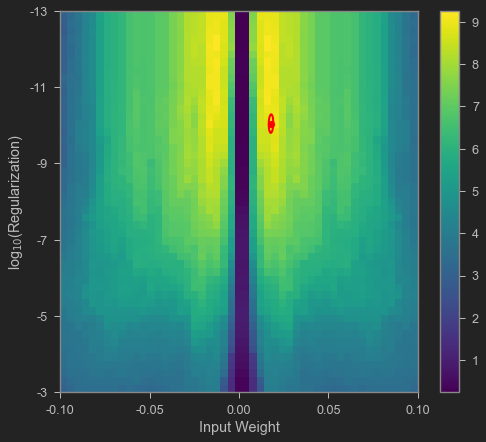

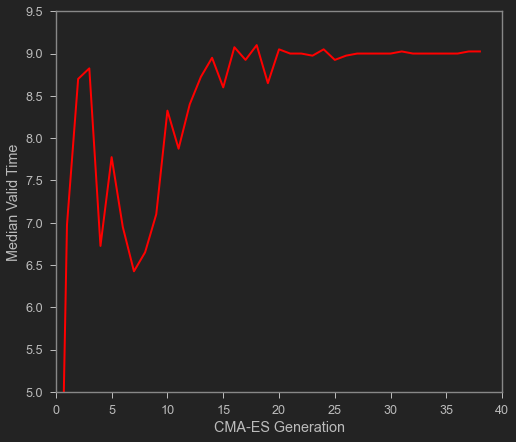

In [28]:
from matplotlib.animation import FuncAnimation
step = 0.05

covmats = np.loadtxt('cmaes_norm_res1/covmats.txt', delimiter = ',')
mean_data = np.loadtxt('cmaes_norm_res1/phenomean.txt', delimiter = ',')[2:]
num_frames = mean_data.shape[0]
func_vals = np.loadtxt('norm_func_vals_01.csv', delimiter = ',')*step
mean_func = pd.read_csv('cmaes_norm_res1/fit.dat', sep = ' ', header = None, skiprows = [0]).to_numpy()[:,5]*step

weights = np.linspace(4.5,5.5,50)
regs = np.linspace(0,10,50)
W, R = np.meshgrid(weights, regs)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

def init_base(ax,W,R,func_vals):
    ax.clear()
    plt.pcolor(W, R, -func_vals.T)
    plt.colorbar()
    ax.set_xlim(4.5,5.5)
    ax.set_ylim(0,10)
    xticks = np.linspace(4.5,5.5,5)
    yticks = np.linspace(0,10,6)
    xlabels = ['%.2f'%i for i in 0.2*(xticks-5.)]
    ylabels = ['%.0f'%i for i in -yticks-3.0]
    plt.xticks(xticks, xlabels)
    plt.yticks(yticks, ylabels)
    plt.xlabel('Input Weight')
    plt.ylabel('log$_{10}$(Regularization)')

def animate(i,ax,mean_data,covmats,W, R, func_vals):
    ax.clear()
    plt.pcolor(W, R, -func_vals.T)
    # if i == 0:
        # plt.colorbar()
    ax.set_xlim(4.5,5.5)
    ax.set_ylim(0,10)
    confidence_ellipse(mean_data[i,0],mean_data[i,1],covmats[i,:].reshape(2,2),ax,edgecolor = 'red', linewidth = 2)
    ax.scatter(mean_data[i,0],mean_data[i,1],c = 'red')
    xticks = np.linspace(4.5,5.5,5)
    yticks = np.linspace(0,10,6)
    xlabels = ['%.2f'%i for i in 0.2*(xticks-5.)]
    ylabels = ['%.0f'%i for i in -yticks-3.0]
    plt.xticks(xticks, xlabels)
    plt.yticks(yticks, ylabels)
    plt.xlabel('Input Weight')
    plt.ylabel('log$_{10}$(Regularization)')
    
update = lambda i: animate(i,ax,mean_data,covmats,W,R,func_vals)
init = lambda : init_base(ax,W,R,func_vals)

ani = FuncAnimation(fig, update, frames = num_frames, init_func = init, blit = False)

ani.save('test.gif')
fig.show()

fig2 = plt.figure()

ax2 = fig2.add_subplot(1,1,1)
line, = ax2.plot([],[],lw = 2, color = 'red')

def init2(ax2, line):
    ax2.set_xlim(0,40)
    ax2.set_ylim(5,9.5)
    ax2.set_xlabel('CMA-ES Generation')
    ax2.set_ylabel('Median Valid Time')
    ax2.grid()
    line.set_data([],[])
    return line,

def animate2(i, line, mean_func):
    line.set_data(np.arange(i+1),np.append(np.array([0]),-mean_func[:i]))
    return line,
    

init_fun = lambda : init2(ax2, line)    
update2 = lambda i: animate2(i,line, mean_func)

ani2 = FuncAnimation(fig2, update2, frames = num_frames, init_func = init_fun, blit = True)

ani2.save('test2.gif')



In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')


fig = plt.figure()
ax = plt.axes(xlim=(0, 4), ylim=(-2, 2))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    x = np.linspace(0, 4, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)
plt.show()


In [ ]:
func_vals = np.loadtxt('norm_func_vals.csv', delimiter = ',')
plt.pcolor(W, R, -func_vals.T)
plt.colorbar()
plt.show()

In [ ]:
res2 = reservoir(3,210,forget = 1, input_weight = 0.25*0.05735187596920699, regularization = 10**(-9.310114193664688), seed = 3)
num_tests = 5000
pred_length = 500
train_length = 400
sync_length = 200
valid_times_norm = cross_validation_performance_resync(scaled_data,res2,num_tests,sync_length, \
   train_length, pred_length,train_method = 'Normal', progress = True)
print(np.median(valid_times_norm))

In [ ]:
valid_times_RLS = cross_validation_performance(scaled_data,res1,num_tests,sync_length, \
   train_length, pred_length,train_method = 'RLS')
print(np.median(valid_times_RLS))
valid_times_norm = cross_validation_performance(scaled_data,res2,num_tests,sync_length, \
   train_length, pred_length,train_method = 'Normal')
print(np.median(valid_times_norm))

In [ ]:
res1 = reservoir(3,300,forget = 0.985, input_weight = 0.01, regularization = 1e-8, \
     t_regularization = 5e-5, delta = 1e6, t_weighted = True)

In [ ]:
# valid_times_norm_array = np.loadtxt('Lorenz63Data/valid_times_norm_tweight_forget%f_reg%e_treg%e.csv' \
#     %(res1.forget, res1.regularization, res1.t_regularization), delimiter = ',')

In [ ]:
step = 0.05
base_data_length = 25000
data_length = int(base_data_length * step/(0.01))
r_t = lambda x: r_t_cosine(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)
valid_times_norm_array = np.array([])

sync_length = 1000
num_tests = 300
train_length = 800
pred_length = 200
completed_seeds = valid_times_norm_array.shape[0]

# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
from tqdm import tqdm
with tqdm(total = num_tests) as pbar:
    for seed in range(num_tests):
        data = getLorenzData(data_length, r_t, dxdt, sample_tau = step, seed = seed)
        scaled_data = np.ascontiguousarray(data)
        valid_times_norm = cross_validation_performance_versust(scaled_data,res1,sync_length, \
               train_length, pred_length,pred_gap_length = 100, train_method = 'Normal', progress = False)
        if valid_times_norm_array.size == 0:
            valid_times_norm_array = np.copy(valid_times_norm)
        else:
            valid_times_norm_array = np.vstack((valid_times_norm_array,valid_times_norm))
        np.savetxt('Lorenz63Data/valid_times_norm_tweight_forget%f_reg%e_treg%e.csv' %(res1.forget, res1.regularization, res1.t_regularization), \
            valid_times_norm_array, delimiter = ',')
        pbar.update(1)

In [ ]:
np.savetxt('Lorenz63Data/valid_times_norm_tweight_forget%f_reg%e_treg%e.csv' %(res1.forget, res1.regularization, res1.t_regularization), \
    valid_times_norm_array, delimiter = ',')

In [ ]:
plt.plot(np.mean(valid_times_norm_array*0.05,axis = 0))
plt.ylim(0,5)
plt.show()

In [ ]:
res1 = reservoir(3,300,forget = 0.985, input_weight = 0.01, LM_regularization = 1e-10, \
     t_regularization = 0, delta = 1e6, t_weighted = False, RLS_reg_type = 'LM')
step = 0.05
base_data_length = 5000
data_length = int(base_data_length * step/(0.01))
r_t = lambda x: r_t_cosine(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)
valid_times_norm_array = np.array([])

sync_length = 500
num_tests = 100
train_length = 2000
pred_length = 400

In [ ]:
data = getLorenzData(data_length, r_t, dxdt, sample_tau = step, seed = 1)
new_data = np.ascontiguousarray(data)

In [ ]:
res1.trainWoutRLS(scaled_data[2800:3800],200)
res1.valid_time(scaled_data[3800:4200],plot = True, error_bound = 3.2)

In [ ]:
valid_times_norm = cross_validation_performance_separated(scaled_data,res1,sync_length, \
               train_length, pred_length, train_method = 'RLS', progress = False)
print(np.median(valid_times_norm))

In [ ]:
# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
from tqdm import tqdm
with tqdm(total = num_tests) as pbar:
    for seed in range(num_tests):
        data = getLorenzData(data_length, r_t, dxdt, sample_tau = step, seed = seed)
        scaled_data = np.ascontiguousarray(data)
        valid_times_norm = cross_validation_performance_versust(scaled_data,res1,sync_length, \
               train_length, pred_length,pred_gap_length = 100, train_method = 'RLS', progress = False)
        if valid_times_norm_array.size == 0:
            valid_times_norm_array = np.copy(valid_times_norm)
        else:
            valid_times_norm_array = np.vstack((valid_times_norm_array,valid_times_norm))
        np.savetxt('Lorenz63Data/valid_times_rls_tweight_forget%f_reg%e_treg%e.csv' %(res1.forget, \
            res1.regularization, res1.t_regularization), valid_times_norm_array, delimiter = ',')
        pbar.update(1)

In [ ]:
plt.plot(np.mean(valid_times_norm_array*0.05,axis = 0))
plt.ylim(0,5)
plt.show()

In [ ]:
x = np.array([[1,2],[3,4]])
np.mean(x,axis = 1)